In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob

In [2]:
### changes in physics - seasonal avg
sst_delta = 0.5 #change in SST, deg/yr?
mld_delta = 10 #change in MLD, m/yr
ot_delta = 5 # change in OT, Sv/yr (SV = 1e6 m3/s)

#### gradients in BGC
grad_dDICdz = 0.28 # (umol/L/m) average between 0-100m depth and 100-200m
grad_DIC_surfdeep = 120 #umol/L between surface and 1000m depth
grad_dFedz = 0.0007 #(nmol/L/m) (nmol/L/m)
grad_dFev = 0.4 # deep minus surface ocean (nmol/L) between surface and 1000m depth (based on Tagliabue 2012 database)

### mean ecosystem parameters
mu_L = 1 # 0-1 depending on month  (Light limitation; no units)
dmudFe = 0.59 # (1/d/(nmolFe/L)) see worksheet Fer parameters "C-estimations-v2"
diatconc = 1 # mean diatom concentration (umol/L)
efratio = 0.5

### carbonate system variables
mn_kg = 0.065 # (mol/m2/yr/ppm) xx-TJ I don't know what this is
mn_SST = 2 #(oC)
mn_Revfact = 14 # Definition: R=(dCO2/CO2)/(dDIC/DIC)
mn_DIC = 2120 # (umol/L)
mn_TA = 2290 # (ueq/L)
mn_pCO2 = 380 # (ppm)

# conversions/ geography
PgC_mol = 1.2e-14 # pgC/mol
SO_area = 5.94e13 # assuming 1/6 of the global ocean south of 50S, calculate this from mesh mask


In [3]:
def effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area):
    
    dfco2 = mn_kg*0.04*mn_pCO2*sst_delta #dfCO2 = kg(4%-pCO2/degree x dSST)
    dfco2_pgCyr_SST = dfco2 * PgC_mol * SO_area #dfCO2 in PgC/yr

    return dfco2_pgCyr_SST

def effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area,\
                grad_dFedz, dmudFe, mu_L, diatconc, efratio):
    #dic
    dDIC = mld_delta*grad_dDICdz #dDIC = dMLD x dDIC/dz, umol/L
    dpCO2 = mn_Revfact * mn_pCO2 / mn_DIC * dDIC #dpCO2 = R x pCO2/DIC x dDIC, ppm
    dfCO2_DIC = mn_kg * dpCO2 #dfCO2_DIC = kg x dpCO2
    dfco2_pgCyr_MLD_DIC = dfCO2_DIC * PgC_mol * SO_area 

    ##ta
    dfcCO2_TA = (-1/3)*dfCO2_DIC
    dfco2_pgCyr_MLD_TA = dfcCO2_TA * PgC_mol * SO_area 

    #iron (ecosystem)
    dFe = mld_delta *  grad_dFedz #dFe = dMLD x dFe/dz 
    #print(dFe)
    dDIC_fe = -1 * dmudFe * dFe * mu_L * diatconc * 365.25 * efratio#dDIC = -dmu/dFe x dFe x mu_L x DIA x dtime  
    print(dDIC_fe)
    dpCO2_Fe = mn_Revfact * mn_pCO2 / mn_DIC * dDIC_fe  #dpCO2 = R x pCO2/DIC x dDIC
    #print(dpCO2_Fe)
    dfCO2_Fe = mn_kg * dpCO2_Fe
    #print(dfCO2_Fe)
    dfco2_pgCyr_MLD_Fe = dfCO2_Fe * PgC_mol * SO_area
    #print(dfco2_pgCyr_MLD_Fe)

    return dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe

def effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc, efratio):

    dfco2_pgCyr_OT_DIC = ot_delta * 1e6 * grad_DIC_surfdeep * 1000*31560000*0.000001*0.000000000000012 #dfCO2_DIC = dOverturning x (dDICv)
    dfco2_pgCyr_OT_TA = -(1/3)*dfco2_pgCyr_OT_DIC #dfCO2_TA = -1/3 x dfCO2_DIC
    #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dDICv = -dmudFe* grad_dFev * mu_L * diatconc * 365.25 * efratio #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dfco2_pgCyr_OT_Fe = dDICv * ot_delta * 1e6 * 1000*31560000*0.000001*0.000000000000012 # dfCO2_DIC = dOverturning x (dDIC)

    return dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe


def give_me_summary(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area,\
                    mld_delta, grad_dDICdz, mn_Revfact, mn_DIC, grad_dFedz, dmudFe, mu_L, diatconc,\
                    ot_delta,grad_DIC_surfdeep, grad_dFev, efratio, verbose = False): 

    dfco2_pgCyr_SST  = effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area)

    dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe = \
        effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area, grad_dFedz, dmudFe, mu_L, diatconc, efratio)

    dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe = \
        effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc, efratio)
    
    CO2_SST = dfco2_pgCyr_SST
    CO2_MLD_phys_chem = dfco2_pgCyr_MLD_TA + dfco2_pgCyr_MLD_DIC
    CO2_OT_phys_chem = dfco2_pgCyr_OT_TA + dfco2_pgCyr_OT_DIC
    CO2_OT_MLD_bio = dfco2_pgCyr_OT_Fe + dfco2_pgCyr_MLD_Fe
    CO2_tot = CO2_SST + CO2_MLD_phys_chem + CO2_OT_phys_chem + CO2_OT_MLD_bio
    if verbose:
        
        print('individual effects')
        print(f'effect SST pgC/yr {dfco2_pgCyr_SST}')
        print(f'effect MLD (TA, DIC, Fe) pgC/yr {dfco2_pgCyr_MLD_DIC}, {dfco2_pgCyr_MLD_TA}, {dfco2_pgCyr_MLD_Fe}')
        print(f'effect OT (TA, DIC, Fe) pgC/yr {dfco2_pgCyr_OT_DIC}, {dfco2_pgCyr_OT_TA}, {dfco2_pgCyr_OT_Fe}')

        print('')
        print('--summary (in PgC/yr)')
        print(f'Change in CO2 flux due to SST change {CO2_SST}')
        print(f'Change in CO2 flux due to MLD change (combined physico-chemical effects) {CO2_MLD_phys_chem}')
        print(f'Change in CO2 flux due to Overturning change (combined physico-chemical effects) {CO2_OT_phys_chem}')
        print(f'Change in CO2 flux due to MLD+Overturning change (ecosystem effects) {CO2_OT_MLD_bio}')
        print(f'Total change in CO2 flux {CO2_tot}')

        return CO2_SST, CO2_MLD_phys_chem, CO2_OT_phys_chem, dfco2_pgCyr_MLD_Fe, dfco2_pgCyr_OT_Fe, CO2_tot

def plot_co2res(CO2_SST, CO2_MLD_phys_chem, CO2_OT_phys_chem,CO2_MLD_bio, CO2_OT_bio, CO2_tot):
    fig = plt.figure()
    ms = 7
    ind = 1
    plt.bar(ind,CO2_tot, color = 'k', width=0.2,\
                label = 'Total $\Delta$ CO2flux (pg)') 
    plt.bar(ind+0.2,CO2_MLD_bio+CO2_OT_bio, width=0.2, color = 'green',\
                label = '$\Delta$ CO2flux due to $\Delta$MLD+OT change \n (ecosystem effects)')  
    plt.bar(ind+0.4,CO2_SST, color = 'b', width=0.2,\
                label = '$\Delta$ CO2flux due to $\Delta$ SST')
    plt.bar(ind+0.6,CO2_OT_phys_chem, color = 'r', width=0.2,\
                label = '$\Delta$ CO2flux due to $\Delta$ OT \n (combined phys.-chem. effects)')    
    plt.bar(ind+0.8,CO2_MLD_phys_chem, color = 'y', width=0.2,\
                label = '$\Delta$ CO2flux due to $\Delta$ MLD \n (combined phys.-chem. effects)')   

    plt.legend(bbox_to_anchor = [1,1])

    plt.show()
#         dfco2_pgCyr_SST = effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area)
#         dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe = effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area)


-0.75424125
individual effects
effect SST pgC/yr 0.3521232
effect MLD (TA, DIC, Fe) pgC/yr 0.3255478641509434, -0.10851595471698113, -0.0876934385685849
effect OT (TA, DIC, Fe) pgC/yr 0.227232, -0.07574399999999999, -0.08161321319999999

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.3521232
Change in CO2 flux due to MLD change (combined physico-chemical effects) 0.21703190943396228
Change in CO2 flux due to Overturning change (combined physico-chemical effects) 0.151488
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) -0.1693066517685849
Total change in CO2 flux 0.5513364576653774


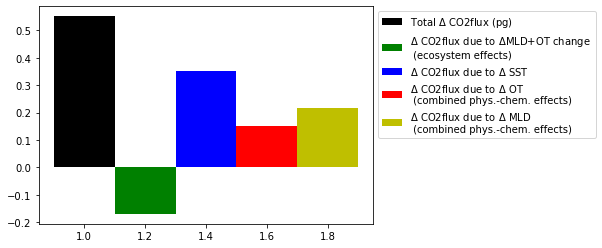

In [4]:
verbose = True
CO2_SST, CO2_MLD_phys_chem, CO2_OT_phys_chem,\
                dfco2_pgCyr_MLD_Fe, dfco2_pgCyr_OT_Fe, CO2_tot =\
                give_me_summary(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area,\
                mld_delta, grad_dDICdz, mn_Revfact, mn_DIC, grad_dFedz, dmudFe, mu_L, diatconc,\
                ot_delta,grad_DIC_surfdeep, grad_dFev, efratio, verbose = verbose)



plot_co2res(CO2_SST, CO2_MLD_phys_chem, CO2_OT_phys_chem,dfco2_pgCyr_MLD_Fe, dfco2_pgCyr_OT_Fe, CO2_tot)

In [5]:
def effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area,\
                grad_dFedz, dmudFe, mu_L, diatconc, efratio):
    #dic
    dDIC = mld_delta*grad_dDICdz #dDIC = dMLD x dDIC/dz, umol/L
    dpCO2 = mn_Revfact * mn_pCO2 / mn_DIC * dDIC #dpCO2 = R x pCO2/DIC x dDIC, ppm
    dfCO2_DIC = mn_kg * dpCO2 #dfCO2_DIC = kg x dpCO2
    dfco2_pgCyr_MLD_DIC = dfCO2_DIC * PgC_mol * SO_area 

    ##ta
    dfcCO2_TA = (-1/3)*dfCO2_DIC
    dfco2_pgCyr_MLD_TA = dfcCO2_TA * PgC_mol * SO_area 

    #iron (ecosystem)
    dFe = mld_delta *  grad_dFedz #dFe = dMLD x dFe/dz 
    #print(dFe)
    dDIC_fe = -1 * dmudFe * dFe * mu_L * diatconc * 365.25 * efratio#dDIC = -dmu/dFe x dFe x mu_L x DIA x dtime  
    print(dDIC_fe)
    dpCO2_Fe = mn_Revfact * mn_pCO2 / mn_DIC * dDIC_fe  #dpCO2 = R x pCO2/DIC x dDIC
    #print(dpCO2_Fe)
    dfCO2_Fe = mn_kg * dpCO2_Fe
    #print(dfCO2_Fe)
    dfco2_pgCyr_MLD_Fe = dfCO2_Fe * PgC_mol * SO_area
    #print(dfco2_pgCyr_MLD_Fe)

    return dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe

In [6]:
def effect_OT_noRfact(ot_delta,grad_DIC_surfdeep):

    'same as just effect_OT'
    
    dfco2_pgCyr_OT_DIC = ot_delta * 1e6 * grad_DIC_surfdeep * 1000*31560000*0.000001*0.000000000000012 #dfCO2_DIC = dOverturning x (dDICv)

    return dfco2_pgCyr_OT_DIC

def effect_OT_withRfact(ot_delta,grad_DIC_surfdeep, SO_area, mn_Revfact, mn_pCO2, PgC_mol):

    dDIC_mol_yr = ot_delta * 1e6 * grad_DIC_surfdeep * 1000*31560000*0.000001  #L/m3 * mol/umol * sec/yr
    dDIC_mol_per_m2 = dDIC_mol_yr/SO_area
    dpCO2 = mn_Revfact * mn_pCO2 / mn_DIC * dDIC_mol_per_m2 #dpCO2 = R x pCO2/DIC x dDIC, ppm
    dfCO2_DIC = mn_kg * dpCO2 #dfCO2_DIC = kg x dpCO2
    dfco2_pgCyr_OT_DIC = dfCO2_DIC * PgC_mol * SO_area 
    
    return dfco2_pgCyr_OT_DIC


def effect_MLD_withRfact(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area,\
               ):
    #dic
    dDIC = mld_delta*grad_dDICdz #dDIC = dMLD x dDIC/dz, umol/L
    dpCO2 = mn_Revfact * mn_pCO2 / mn_DIC * dDIC #dpCO2 = R x pCO2/DIC x dDIC, ppm
    dfCO2_DIC = mn_kg * dpCO2 #dfCO2_DIC = kg x dpCO2
    dfco2_pgCyr_MLD_DIC = dfCO2_DIC * PgC_mol * SO_area 

    return dfco2_pgCyr_MLD_DIC

def effect_MLD_noRfact(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area,\
               ):
    #dic
    dfco2_pgCyr_MLD_DIC = mld_delta*grad_dDICdz * 1000*0.000001*0.000000000000012 * SO_area


    return dfco2_pgCyr_MLD_DIC



orig MLD (DIC+TA) 0.21703190943396225
orig OT (DIC+TA) 0.15148799999999998


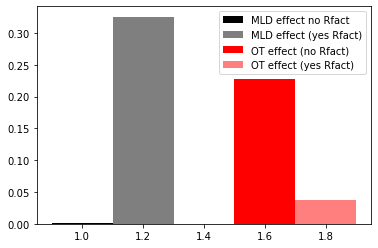

In [7]:
MLD_noRfact = effect_MLD_noRfact(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area)
MLD_withRfact = effect_MLD_withRfact(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area)
OT_noRfact = effect_OT_noRfact(ot_delta,grad_DIC_surfdeep)
OT_withRfact = effect_OT_withRfact(ot_delta,grad_DIC_surfdeep, SO_area, mn_Revfact, mn_pCO2, PgC_mol)

print(f'orig MLD (DIC+TA) {MLD_withRfact * (2/3)}')
print(f'orig OT (DIC+TA) {OT_noRfact * (2/3)}')

fig = plt.figure()
ms = 7
ind = 1
plt.bar(ind,MLD_noRfact, color = 'k', width=0.2,\
            label = 'MLD effect no Rfact') 
plt.bar(ind+0.2,MLD_withRfact, width=0.2, color = 'k', alpha = 0.5,\
            label = 'MLD effect (yes Rfact)')  

plt.bar(ind+0.6,OT_noRfact, color = 'r', width=0.2,\
            label = 'OT effect (no Rfact)')    
plt.bar(ind+0.8,OT_withRfact, color = 'r', alpha = 0.5, width=0.2,\
            label = 'OT effect (yes Rfact)')   

plt.legend(bbox_to_anchor = [1,1])

plt.show()

## overturning and mld with and without rfact 

In [13]:
def effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc, efratio, verbose = True):

    dfco2_pgCyr_OT_DIC = ot_delta * 1e6 * grad_DIC_surfdeep * 1000*31560000*0.000001*0.000000000000012 #dfCO2_DIC = dOverturning x (dDICv)
    dfco2_pgCyr_OT_TA = -(1/3)*dfco2_pgCyr_OT_DIC #dfCO2_TA = -1/3 x dfCO2_DIC
    #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dDICv = -dmudFe* grad_dFev * mu_L * diatconc * 365.25 * efratio #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dfco2_pgCyr_OT_Fe = dDICv * ot_delta * 1e6 * 1000*31560000*0.000001*0.000000000000012 # dfCO2_DIC = dOverturning x (dDIC)

    if verbose:
        print('---no rfact, original eq')
        print(f'DIC ef pgC/yr: {dfco2_pgCyr_OT_DIC} TA ef pgC/yr {dfco2_pgCyr_OT_TA}')
        print(f'ecosystem pgC/yr: {dfco2_pgCyr_OT_Fe}')
    
    return dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe

def effect_OT_withRfact(ot_delta,grad_DIC_surfdeep, SO_area, mn_Revfact, mn_pCO2, PgC_mol, mn_DIC, mn_kg,\
                       dmudFe, grad_dFev, mu_L, diatconc, efratio, verbose = True):

    dDIC_mol_yr = ot_delta * 1e6 * grad_DIC_surfdeep * 1000*31560000*0.000001  #L/m3 * mol/umol * sec/yr
    dDIC_mol_per_m2 = dDIC_mol_yr/SO_area
    dpCO2 = mn_Revfact * mn_pCO2 / mn_DIC * dDIC_mol_per_m2 #dpCO2 = R x pCO2/DIC x dDIC, ppm
    dfCO2_DIC = mn_kg * dpCO2 #dfCO2_DIC = kg x dpCO2
    dfco2_pgCyr_OT_DIC = dfCO2_DIC * PgC_mol * SO_area 
    
    dfco2_pgCyr_OT_TA = (-1/3) * dfco2_pgCyr_OT_DIC
    
    dDIC_Fe = -dmudFe* grad_dFev * mu_L * diatconc * 365.25 * efratio
    dfco2_pgCyr_OT_DIC = dDIC_Fe * ot_delta * 1e6 * 1000*31560000*0.000001*0.000000000000012
    
    dpCO2_Fe = mn_Revfact * mn_pCO2 / mn_DIC * dfco2_pgCyr_OT_DIC  #dpCO2 = R x pCO2/DIC x dDIC
    #print(dpCO2_Fe)
    dfCO2_Fe = mn_kg * dpCO2_Fe
    #print(dfCO2_Fe)
    dfco2_pgCyr_OT_Fe = dfCO2_Fe * PgC_mol * SO_area    
    
    #dDICv = -dmudFe* grad_dFev * mu_L * diatconc * 365.25 * efratio #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    if verbose:
        print('---no rfact, original eq')
        print(f'DIC ef pgC/yr: {dfco2_pgCyr_OT_DIC} TA ef pgC/yr {dfco2_pgCyr_OT_TA}')
        print(f'ecosystem pgC/yr: {dfco2_pgCyr_OT_Fe}')
    
    
    return dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe

DIC, TA, Fe = effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc, efratio, verbose = True)
DIC0, TA0, Fe0 = effect_OT_withRfact(ot_delta,grad_DIC_surfdeep, SO_area, mn_Revfact, mn_pCO2, PgC_mol, mn_DIC, mn_kg,\
                       dmudFe, grad_dFev, mu_L, diatconc, efratio, verbose = True)

---no rfact, original eq
DIC ef pgC/yr: 0.227232 TA ef pgC/yr -0.07574399999999999
ecosystem pgC/yr: -0.08161321319999999
---no rfact, original eq
DIC ef pgC/yr: -0.08161321319999999 TA ef pgC/yr -0.01235484679245283
ecosystem pgC/yr: -0.009488931158484136
